In [138]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import lit
from pyspark.sql.functions import mean, stddev, col

from sklearn import metrics

from math import sqrt
from math import pi
from math import exp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import numpy as np 
from Point import Point

ModuleNotFoundError: No module named 'Point'

# Data Pre-processing

In [122]:
spark = SparkSession.builder.master("local").appName("Colab").getOrCreate()

In [166]:
df = spark.read.csv(r'healthcare-dataset-stroke-data.csv', 
                        sep=',',
                        header=True,
                        inferSchema=True,
                        nullValue='NA')

df.printSchema()
                 

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [118]:
df.count()

5110

In [ ]:
df.toPandas().head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [167]:
numeric_columns = ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
for column in numeric_columns:
  df = df.withColumn(column, df[column].cast(FloatType()))
df.printSchema()

root
 |-- id: float (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- hypertension: float (nullable = true)
 |-- heart_disease: float (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: float (nullable = true)
 |-- bmi: float (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [ ]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,5110,36517.82935420744,21161.72162482715,67.0,72940.0
gender,5110,None,None,Female,Other
age,5110,43.22661448143525,22.61264672306245,0.08,82.0
hypertension,5110,0.0974559686888454,0.296606674233791,0.0,1.0
heart_disease,5110,0.05401174168297456,0.22606298750336554,0.0,1.0
ever_married,5110,None,None,No,Yes
work_type,5110,None,None,Govt_job,children
Residence_type,5110,None,None,Rural,Urban
avg_glucose_level,5110,106.14767708078523,45.2835601574783,55.12,271.74


In [169]:
df = df.toPandas()

In [170]:
df['bmi'].fillna(value=df['bmi'].mean(), inplace=True)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,Male,67.0,0.0,1.0,Yes,Private,Urban,228.690002,36.599998,formerly smoked,1
1,51676.0,Female,61.0,0.0,0.0,Yes,Self-employed,Rural,202.210007,28.893234,never smoked,1
2,31112.0,Male,80.0,0.0,1.0,Yes,Private,Rural,105.919998,32.500000,never smoked,1
3,60182.0,Female,49.0,0.0,0.0,Yes,Private,Urban,171.229996,34.400002,smokes,1
4,1665.0,Female,79.0,1.0,0.0,Yes,Self-employed,Rural,174.119995,24.000000,never smoked,1


In [171]:
data = df.drop(columns=['id', 'ever_married','Residence_type'], axis=1)

In [172]:
data = data.replace(to_replace = 'Male', value = 1)
data = data.replace(to_replace = 'Female', value = 0)
data.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,1.0,Private,228.690002,36.599998,formerly smoked,1
1,0,61.0,0.0,0.0,Self-employed,202.210007,28.893234,never smoked,1
2,1,80.0,0.0,1.0,Private,105.919998,32.500000,never smoked,1
3,0,49.0,0.0,0.0,Private,171.229996,34.400002,smokes,1
4,0,79.0,1.0,0.0,Self-employed,174.119995,24.000000,never smoked,1


In [173]:
data.gender.value_counts()

0        2994
1        2115
Other       1
Name: gender, dtype: int64

In [174]:
data = data.replace(to_replace = 'Other',value = 1)
data.gender.value_counts()

0    2994
1    2116
Name: gender, dtype: int64

In [175]:
data["work_type"] = data["work_type"].astype("category")
data["work_type"] = data["work_type"].cat.codes
data.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,1.0,2,228.690002,36.599998,formerly smoked,1
1,0,61.0,0.0,0.0,3,202.210007,28.893234,never smoked,1
2,1,80.0,0.0,1.0,2,105.919998,32.500000,never smoked,1
3,0,49.0,0.0,0.0,2,171.229996,34.400002,smokes,1
4,0,79.0,1.0,0.0,3,174.119995,24.000000,never smoked,1


In [176]:
data["smoking_status"] = data["smoking_status"].astype("category")
data["smoking_status"] = data["smoking_status"].cat.codes
data.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,1.0,2,228.690002,36.599998,1,1
1,0,61.0,0.0,0.0,3,202.210007,28.893234,2,1
2,1,80.0,0.0,1.0,2,105.919998,32.500000,2,1
3,0,49.0,0.0,0.0,2,171.229996,34.400002,3,1
4,0,79.0,1.0,0.0,3,174.119995,24.000000,2,1


In [177]:
data = spark.createDataFrame(data)

In [178]:
data.show()

+------+----+------------+-------------+---------+------------------+------------------+--------------+------+
|gender| age|hypertension|heart_disease|work_type| avg_glucose_level|               bmi|smoking_status|stroke|
+------+----+------------+-------------+---------+------------------+------------------+--------------+------+
|     1|67.0|         0.0|          1.0|        2|228.69000244140625|36.599998474121094|             1|     1|
|     0|61.0|         0.0|          0.0|        3| 202.2100067138672|28.893234252929688|             2|     1|
|     1|80.0|         0.0|          1.0|        2|105.91999816894531|              32.5|             2|     1|
|     0|49.0|         0.0|          0.0|        2|171.22999572753906|34.400001525878906|             3|     1|
|     0|79.0|         1.0|          0.0|        3| 174.1199951171875|              24.0|             2|     1|
|     1|81.0|         0.0|          0.0|        2| 186.2100067138672|              29.0|             1|     1|
|

In [180]:
data.printSchema()

root
 |-- gender: long (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- heart_disease: double (nullable = true)
 |-- work_type: long (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: long (nullable = true)
 |-- stroke: integer (nullable = true)



In [179]:
data = data.withColumn('stroke', data['stroke'].cast(IntegerType()))

# Data Virtualization

# Data Modeling

## Native Bayes

In [ ]:
class NativeBayes:
    def __init__(self, train, test, label):
        self.train = train
        self.test = test
        self.label = label

    def mean(self, train_y, numbers):
        return (train_y.groupBy().mean(numbers).collect())[0][0]

    def stdev(self, train_y, numbers):
        avg = self.mean(train_y, numbers)
        lendf = len(train_y.select(numbers).collect())
        value = train_y.select(numbers).rdd.flatMap(lambda x: x).collect()
        variance = sum([(x-avg)**2 for x in value]) / float(lendf - 1)
        return sqrt(variance)

    # return mean, stdev, count for each columns in train 
    def summarize_dataset(self, filter_train):
        summaries = [(self.mean(filter_train, column), self.stdev(filter_train, column), filter_train.select(column).count())
                     for column in filter_train.columns]
        del(summaries[-1])
        return summaries

    def summarize_by_class(self, train):
        summaries = dict()
        lenqual = len(train.select([self.label]).rdd.flatMap(
            lambda x: x).distinct().collect())
        for i in range(0, lenqual):
            item = train.select([self.label]).rdd.flatMap(
                lambda x: x).distinct().collect()[i]
            filter_train = train.filter(train[self.label] == item)
            summaries[item] = self.summarize_dataset(filter_train)
        return summaries

    def calculate_class_probabilities(self, summaries, row):
        total_rows = sum([summaries[label][0][2] for label in summaries])
        probabilities = dict()
        for class_value, class_summaries in summaries.items():
            probabilities[class_value] = summaries[class_value][0][2] / \
                float(total_rows)
            for i in range(0, len(class_summaries)):
                mean, stdev, _ = class_summaries[i]
                probabilities[class_value] *= self.calculate_probability(
                    row[i], mean, stdev)
        return probabilities

    def calculate_probability(self, x, mean, stdev):
        exponent = exp(-((x-mean)**2 / (2 * stdev**2)))
        return (1 / (sqrt(2 * pi) * stdev)) * exponent

    def predict(self, summaries, row):
        probabilities = self.calculate_class_probabilities(summaries, row)
        best_label, best_prob = None, -1
        for class_value, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_prob = probability
                best_label = class_value
        return best_label

#   return y label
    def fit(self):
        summarize = self.summarize_by_class(self.train)
        predictions = list()
        for row in self.test.collect():
            output = self.predict(summarize, row)
            predictions.append(output)
        return(predictions)


In [ ]:
native_bayes = NativeBayes(train=train,test=test, label='stroke')

## Logistic regression

In [15]:
def cal_z(x, theta):
    """
    Parameters
    ----------
    x shape: (95, 3) 
    theta shape: (3, 1)
    Returns
    ----------
    z shape (95, 1)
    """
    return np.dot(x, theta)

In [182]:
def sigmoid(z):
    """
    Parameters
    z shape: (95, 1)
    Returns
    output shape: (95, 1)
    """
    return 1 / (1 + np.exp(-z))

In [17]:
def cal_h_theta(x, theta):
    """
    Parameters
    ----------
    x shape: (95, 3)
    theta shape: (3, 1)
    Returns
    ----------
    output shape: (95, 1)
    """
    z = cal_z(x, theta)
    return sigmoid(z)

In [19]:
def loss_function(x, y, theta):
    """
    Parameters
    ----------
    x shape: (95, 3)
    y shape: (95, 1)
    theta shape: (3, 1)
    Returns
    ----------
    loss: float
    """
    h_theta = cal_h_theta(x, theta)
    loss = -(y*np.log(h_theta) + (1-y)*np.log(1-h_theta))
    return np.mean(loss)

In [21]:
def gradient(x, y, theta):
    """
    Parameters
    ----------
    x shape: (95, 3)
    y shape: (95, 1)
    theta shape: (3, 1)
    Returns
    ----------
    grad shape: (3, 1)
    """
    h_theta = cal_h_theta(x, theta)
    grad = np.mean(x*(h_theta-y), axis=0)
    return grad.reshape((grad.shape[0], 1))

In [159]:
X = X.withColumn('X', lit(1))
X.show()

+------+----+------------+-------------+---------+------------------+------------------+--------------+---+
|gender| age|hypertension|heart_disease|work_type| avg_glucose_level|               bmi|smoking_status|  X|
+------+----+------------+-------------+---------+------------------+------------------+--------------+---+
|     1|67.0|         0.0|          1.0|        2|228.69000244140625|36.599998474121094|             1|  1|
|     0|61.0|         0.0|          0.0|        3| 202.2100067138672|28.893234252929688|             2|  1|
|     1|80.0|         0.0|          1.0|        2|105.91999816894531|              32.5|             2|  1|
|     0|49.0|         0.0|          0.0|        2|171.22999572753906|34.400001525878906|             3|  1|
|     0|79.0|         1.0|          0.0|        3| 174.1199951171875|              24.0|             2|  1|
|     1|81.0|         0.0|          0.0|        2| 186.2100067138672|              29.0|             1|  1|
|     1|74.0|         1.0|  

In [30]:
theta = np.zeros((len(X.columns), 1))

In [31]:
theta

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [181]:
train, test = data.randomSplit([0.7, 0.3])

In [161]:
def normalize(train, test):
    stats = {}

    for column in train.columns:
        df_stats = train.select(
            mean(col(column)).alias('mean'),
            stddev(col(column)).alias('std')
        ).collect()
        stats[column] = {
            'mean': df_stats[0]['mean'],
            'std': df_stats[0]['std']
        }

    for column in train.columns:
        if(column == 'X'): continue
        train = train.withColumn(column, (col(column) - stats[column]['mean']) / stats[column]['std'])
    
    for column in test.columns:
        df_stats = test.select(
            mean(col(column)).alias('mean'),
            stddev(col(column)).alias('std')
        ).collect()
        stats[column] = {
            'mean': df_stats[0]['mean'],
            'std': df_stats[0]['std']
        }

    for column in test.columns:
        if(column == 'X'): continue
        test = test.withColumn(column, (col(column) - stats[column]['mean']) / stats[column]['std'])
    return train, test

In [162]:
train_x, test_x = normalize(train, test)

AttributeError: 'PipelinedRDD' object has no attribute 'columns'

In [204]:
train.count()

3561

In [147]:
test_x.count()

1517

In [184]:
def predict(X, theta):
    prob = sigmoid(np.dot(X, theta))
    return [1 if x >= 0.5 else 0 for x in prob]

In [152]:
def sigmoid(z):
    return 1.0 / (1.0 + Positiveexp(-z))

SyntaxError: invalid character in identifier (<ipython-input-152-2f98959edde4>, line 1)

In [212]:
def gradient_descent(X, theta, alpha, num_inters):
    m = X.count()
    for i in range(num_inters):
        delta = X.map(
            lambda p: np.array(p['x']) * (sigmoid(np.dot(p['x'], theta))-p['y'])).reduce(lambda x, y: x+y)
        
        theta -= delta*alpha/m
    return theta

In [213]:
theta = np.zeros(len(train.columns)-1)

data = train.rdd.map(list).map(lambda p: { 'x': p[:len(p)-1], 'y': p[-1]})

theta = gradient_descent(data, theta, 0.1, 1000)


In [214]:
theta

array([-0.05411841,  0.99681122,  0.45966052,  0.4070953 , -1.00448804,
       -0.27415932, -3.14730214, -0.41677919])

In [ ]:
num_epoches = 10000
learning_rate = 0.1



for e in range(num_epoches):
    # Tính gradient
    grad = gradient(train_x, train_y, theta)
    
    # Update theta
    theta = theta - learning_rate * grad
    total_loss = loss_function(train_x, train_y, theta)
    
    
    if e % 1000 == 0:
        print(total_loss)
    
print('Training finished')

In [221]:
rdd_kq = test.rdd.map(lambda x:(sigmoid(sum(float(x[i])*float(theta[i]) for i in range(len(x)-1)))))
rdd_kq = rdd_kq.map(lambda x: (1 if x >=0.5 else 0))



[[1472    0]
 [  76    1]]


Text(0.5, 1.0, 'Accuracy Score: 0.95')

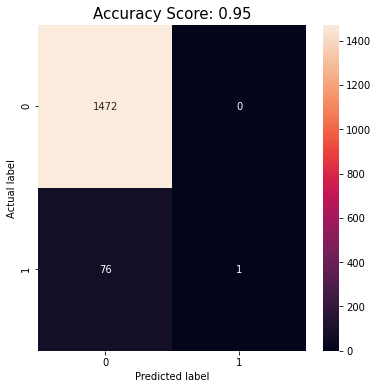

In [229]:
actual = test.select('stroke').rdd.flatMap(lambda x: x).collect()
predicted = rdd_kq.collect()

y_true = np.array(actual).astype(int)
y_pred = np.array(predicted).astype(int)

accuracy = acc(y_true, y_pred)
# accuracy = accuracy_metric(actual, predicted)

cm = generate_confusion_matrix(y_true, y_pred)

# plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='.0f')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Accuracy Score: {0}'.format(round(accuracy,2))
plt.title(title, size=15)

# Model evaluation

In [33]:
train, test = data.randomSplit([0.7, 0.3], seed = 2222)

In [17]:
def evaluate_algorithm(algorithm, label):
    predicted = algorithm()
    actual = test.select(label).rdd.flatMap(lambda x: x).collect()

    y_true = np.array(actual).astype(int)
    y_pred = np.array(predicted).astype(int)

    accuracy = acc(y_true, y_pred)
    # accuracy = accuracy_metric(actual, predicted)
    
    cm = generate_confusion_matrix(y_true, y_pred)

    # plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.0f')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Accuracy Score: {0}'.format(round(accuracy,2))
    plt.title(title, size=15)

In [226]:
def acc(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return float(correct)/y_true.shape[0]


In [225]:
def generate_confusion_matrix(y_true, y_pred):
    N = np.unique(y_true).shape[0] # number of classes 
    cm = np.zeros((N, N))

    for n in range(y_true.shape[0]):
        cm[y_true[n], y_pred[n]] += 1
    print(cm.astype(int))
    return cm.astype(int)

[[1301  144]
 [  37   26]]


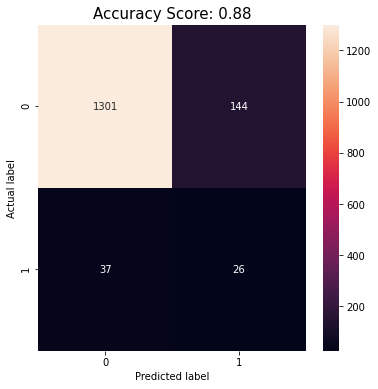

In [ ]:
evaluate_algorithm(native_bayes.fit, 'stroke')